1. Importing packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Loading dataset

In [4]:
df = pd.read_csv('text.csv')
df.head(10)

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
5,5,i was beginning to feel quite disheartened,0
6,6,i would think that whomever would be lucky eno...,2
7,7,i fear that they won t ever feel that deliciou...,1
8,8,im forever taking some time out to have a lie ...,5
9,9,i can still lose the weight without feeling de...,0


In [5]:
df.columns

Index(['Unnamed: 0', 'text', 'label'], dtype='object')

In [6]:
# We have droped the extra column 
df.drop(columns='Unnamed: 0', inplace=True)

In [7]:
# checking the shape
print(f'The Shape Of Data Is : {df.shape}')

The Shape Of Data Is : (416809, 2)


In [8]:
# checking the duplicates we have found some so we are going to remove them 
df.duplicated().sum()

686

In [9]:
# removing the duplicates
df = df.drop_duplicates()

In [10]:
# rechecking the duplicates
df.duplicated().sum()

0

DATA CLEANING

In [11]:
# we need to map the data so we can get the good visualization
emotion_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
    # Add more mappings as needed
}

df['label'] = df['label'].map(emotion_map)

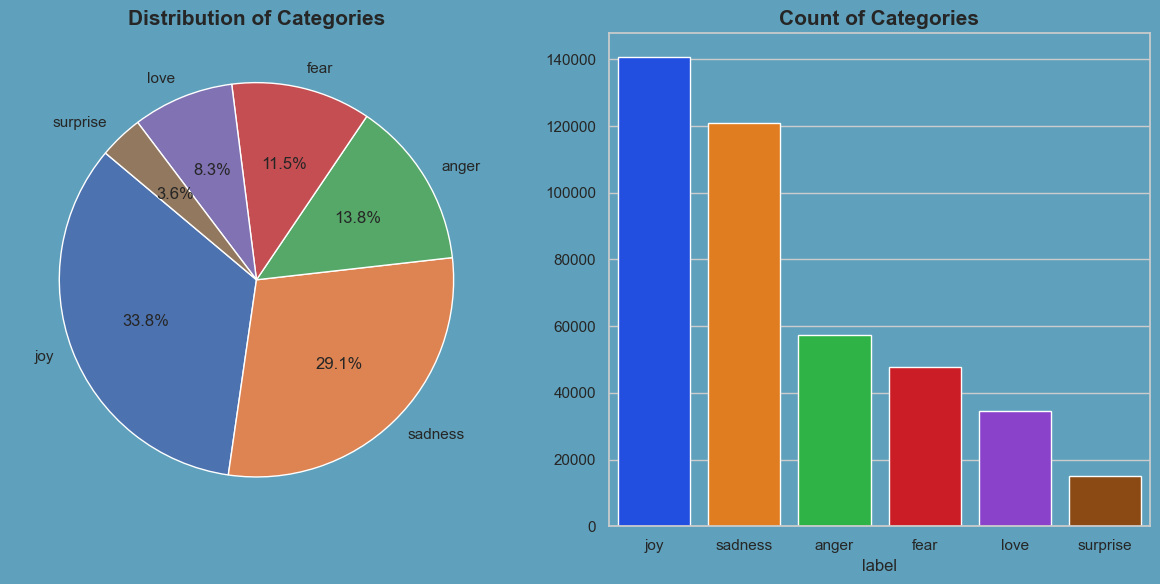

In [12]:
# Value count of 'label'
count = df['label'].value_counts()

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color, 'figure.facecolor': background_color})

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor=background_color)

# Plot pie chart on the first subplot
palette = sns.color_palette("bright", len(count))
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories', fontsize=15, fontweight='bold')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette=palette)
axs[1].set_title('Count of Categories', fontsize=15, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

DATA CLEANING

Textual Data Cleaning is Important Because:

Improving Accuracy: Clean data leads to more accurate analysis and modeling results. Removing irrelevant or incorrect information ensures that the analysis is based on reliable data.

Enhancing Readability: Cleaned text is easier to read and understand. This is important for communication, especially in business reports, articles, and other forms of written content.

Removing Noise: Text data often contains noise in the form of special characters, punctuation, and other unnecessary elements. Cleaning helps remove this noise, focusing on the relevant content.

Standardization: Cleaning involves standardizing text by converting it to a consistent format. This helps in matching and comparing text data accurately.

Preventing Biases: Text cleaning can help reduce biases in data analysis. For example, removing gender-specific pronouns can help prevent gender bias in sentiment analysis.

Improving Efficiency: Cleaned data leads to more efficient processing and analysis. Algorithms can work more effectively on clean, structured data.

Data Integration: Clean data is easier to integrate with other datasets, enabling comprehensive analysis and insights.

CHAT WORDS
Chat words are informal expressions used in online communication, like "lol" and "brb."

They need to be handled in text processing to normalize and understand them.

Handling chat words is crucial for accurate analysis, especially in sentiment analysis and chatbot development.

Preprocessing chat words improves user experience and ensures correct interpretation in conversational interfaces.

In [13]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [14]:
# Function to replace chat words with their full forms
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

# Apply replace_chat_words function to 'Text' column
df['text'] = df['text'].apply(replace_chat_words)

NON ALPHA NUMERIC CHARACTERS

In [15]:
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

df.head()

,text,label
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sadness
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sadness
4,i am a kindergarten teacher and i am thoroughl...,fear


STOP WORDS

In [16]:
stop = stopwords.words('english')
df["text"] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df.head()

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear


Lowercasing

In [17]:
df['text'] = df['text'].str.lower()
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


REMOVING NUMERIC

In [18]:
df['text'] = df['text'].str.replace(r'\d+', '', regex=True)
df.head()

,text,label
0,feel really helpless heavy hearted,fear
1,ive enjoyed able slouch relax unwind frankly n...,sadness
2,gave internship dmrg feeling distraught,fear
3,dont know feel lost,sadness
4,kindergarten teacher thoroughly weary job take...,fear


REMOVING WHITE SPACE

In [19]:
df['text'] = df['text'].str.replace(r'\s+', ' ', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


REMOVING SPECIAL CHARACTER

In [20]:
df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


REMOVING URLS

In [21]:
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)
print(df.head())

                                                text    label
0                 feel really helpless heavy hearted     fear
1  ive enjoyed able slouch relax unwind frankly n...  sadness
2            gave internship dmrg feeling distraught     fear
3                                dont know feel lost  sadness
4  kindergarten teacher thoroughly weary job take...     fear


DATA VISUALIZATION

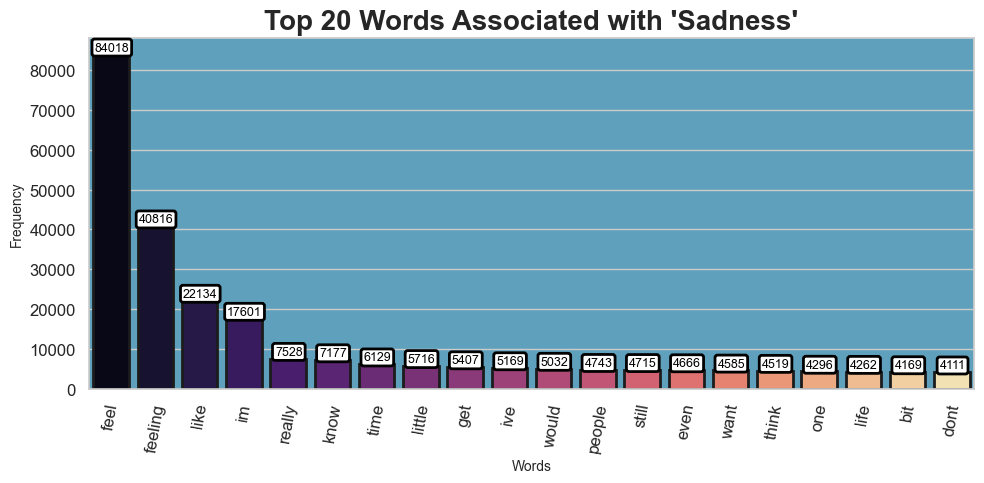

In [22]:
love_texts = df[df['label'] == 'sadness']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Sadness'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Top 20 Words Associated with 'Love'

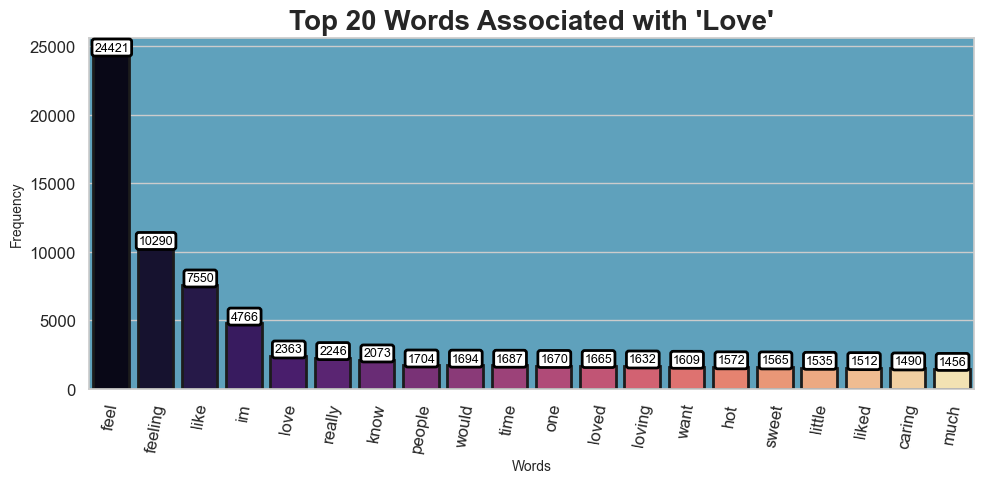

In [23]:
love_texts = df[df['label'] == 'love']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Love'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Top 20 Words Associated with 'Joy'

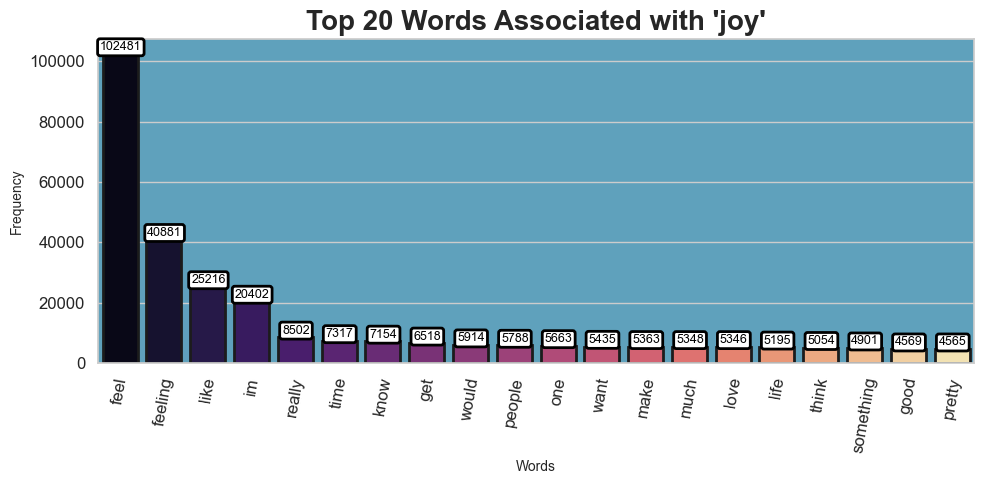

In [24]:
love_texts = df[df['label'] == 'joy']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'joy'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Top 20 Words Associated with 'Anger'

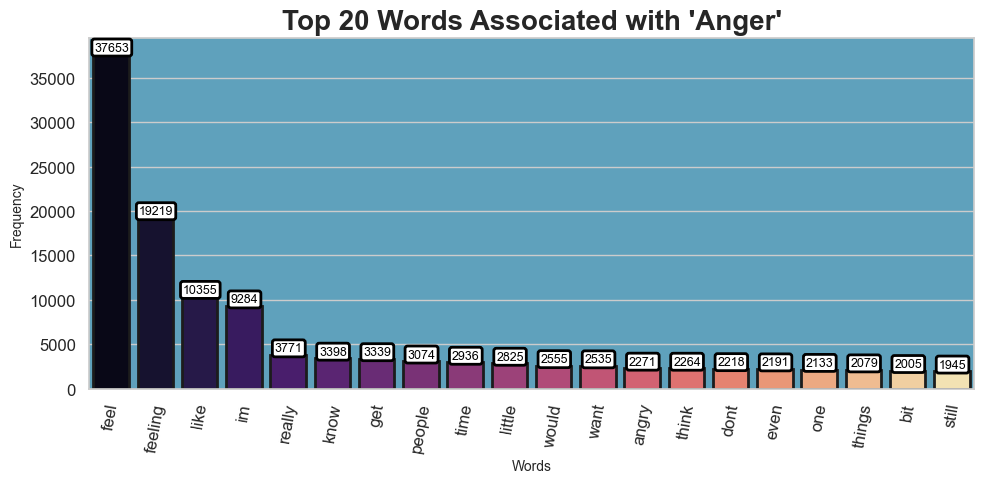

In [25]:
love_texts = df[df['label'] == 'anger']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Anger'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Top 20 Words Associated with 'Fear'

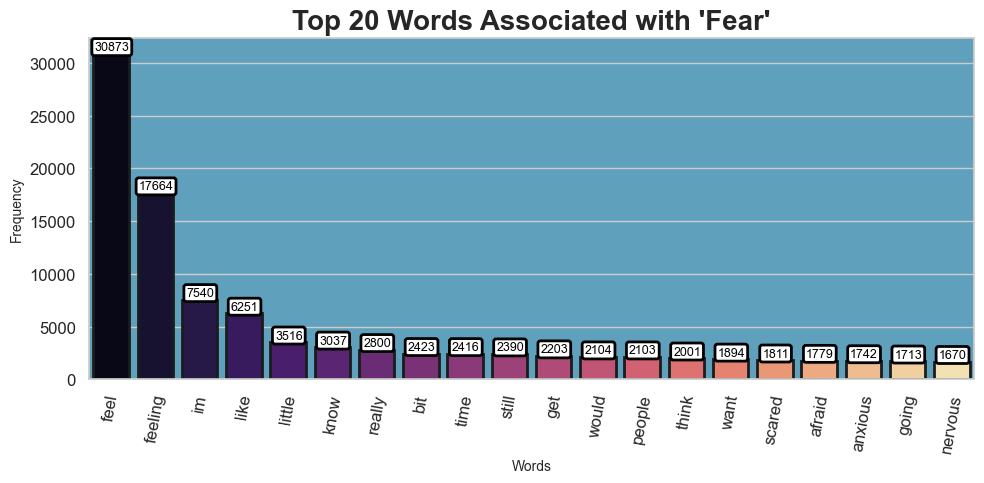

In [26]:
love_texts = df[df['label'] == 'fear']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Fear'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Top 20 Words Associated with 'Surprise'

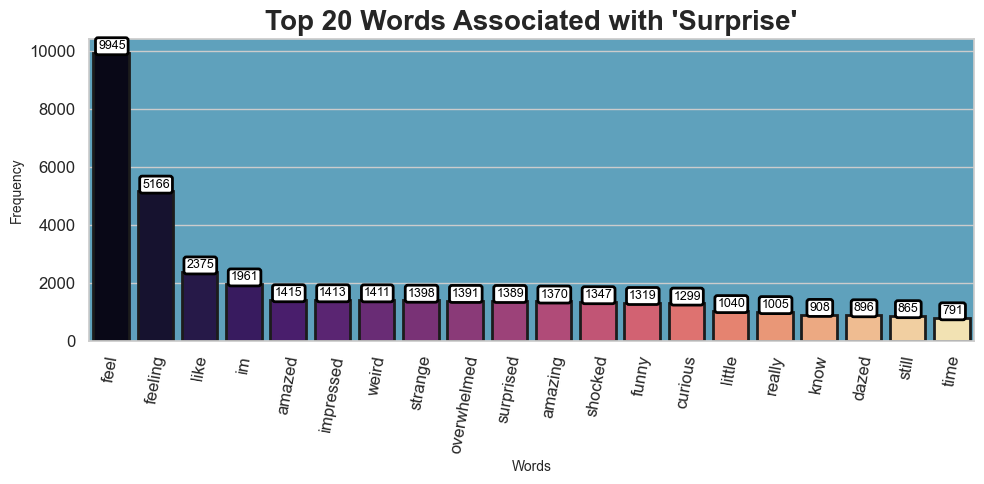

In [27]:
love_texts = df[df['label'] == 'surprise']['text']

# Tokenize the text and count the frequency of each word
words = [word.lower() for text in love_texts for word in word_tokenize(text)]
word_freq = Counter(words)

# Get the top 20 words
top_20_words = dict(word_freq.most_common(20))

# Set the background color and themesss
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color})

# Create a bar plot
plt.figure(figsize=(10, 5))
p = sns.barplot(x=list(top_20_words.keys()), y=list(top_20_words.values()), palette='magma', edgecolor='#1c1c1c', linewidth=2)
for container in p.containers:
    plt.bar_label(container, label_type="edge", color="black", fontsize=9, padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "white", "edgecolor": "black", "linewidth": 2, "alpha": 1})
plt.title("Top 20 Words Associated with 'Surprise'", fontsize=20, fontweight='bold')
plt.xlabel("Words", fontsize=10 )
plt.ylabel("Frequency", fontsize=10)
plt.xticks(rotation=80, fontsize=12,)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Looking at the cleaned data

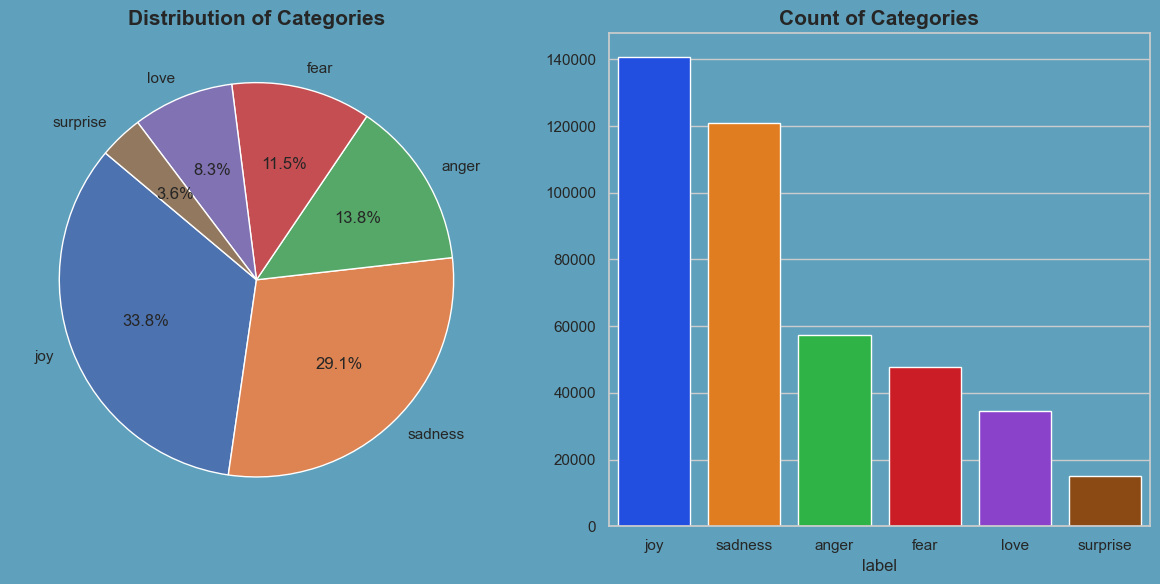

In [28]:
# Value count of 'label'
count = df['label'].value_counts()

# Set the background color and theme
background_color = '#5fa1bc'
sns.set_theme(style="whitegrid", rc={"axes.facecolor": background_color, 'figure.facecolor': background_color})

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor=background_color)

# Plot pie chart on the first subplot
palette = sns.color_palette("bright", len(count))
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories', fontsize=15, fontweight='bold')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette=palette)
axs[1].set_title('Count of Categories', fontsize=15, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

BiLSTM model

In [29]:
# Define a mapping dictionary
label_mapping = {'sadness':0, 'joy':1, 'love':2, 'anger':3, 'fear':4,'surprise':5}

# Rename the 'Label' column using the mapping dictionary
df['label'] = df['label'].map(label_mapping)

In [30]:
df.head()

,text,label
0,feel really helpless heavy hearted,4
1,ive enjoyed able slouch relax unwind frankly n...,0
2,gave internship dmrg feeling distraught,4
3,dont know feel lost,0
4,kindergarten teacher thoroughly weary job take...,4


Training

In [31]:
# splitting the data 
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']

# Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("The shape of X_train is ", X_train.shape)
print("The shape of X_test is ", X_test.shape)
print("The shape of y_train is", y_train.shape)
print("The shape of y_test is", y_test.shape)

The shape of X_train is  (332898,)
The shape of X_test is  (83225,)
The shape of y_train is (332898,)
The shape of y_test is (83225,)


Tokenizer

In [34]:
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
# Maximum Length in X_train_sequences
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 79


In [35]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

In [36]:
# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[2513   13 2430 ...    0    0    0]
 [   1  845  392 ...    0    0    0]
 [   1  659   83 ...    0    0    0]
 ...
 [1453   24    1 ...    0    0    0]
 [   6   13  262 ...    0    0    0]
 [ 171  102    2 ...    0    0    0]]

X_test_padded:
[[   6  213  146 ...    0    0    0]
 [   2  223   32 ...    0    0    0]
 [ 189   11    1 ...    0    0    0]
 ...
 [   1  563 1097 ...    0    0    0]
 [   4  303 8707 ...    0    0    0]
 [   1    3  105 ...    0    0    0]]


In [37]:
# Embedding Input Size
input_size = np.max(X_train_padded) + 1
input_size

60000

Building the model

In [38]:
# Define the model
model = Sequential()

# Add an embedding layer 
model.add(Embedding(input_dim=input_size, output_dim=100,input_shape=(79,)))

# Add a bidirectional GRU layer with 128 units
model.add(Bidirectional(LSTM(128)))

# Add batch normalization layer
model.add(BatchNormalization())

# Add dropout regularization
model.add(Dropout(0.5))

# Add a dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

# Add dropout regularization
model.add(Dropout(0.5))

# Add the output layer with 6 units for 6 labels and softmax activation
model.add(Dense(6, activation='softmax'))

In [39]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 79, 100)        │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,252,358 (23.85 MB)

 Trainable params: 6,251,846 (23.85 MB)

 Non-trainable params: 512 (2.00 KB)

In [40]:
# Model Train 
history = model.fit(X_train_padded, y_train, epochs=15, batch_size=32, validation_data=(X_test_padded, y_test),callbacks=[EarlyStopping(patience=3)])

Epoch 1/15
  762/10404 ━━━━━━━━━━━━━━━━━━━━ 12:20 77ms/step - accuracy: 0.5244 - loss: 1.2333

KeyboardInterrupt: 